# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning)

In [2]:
# Check to see if we're using a GPU
!nvidia-smi

Mon Apr  3 15:00:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-03 15:00:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-03 15:00:05 (75.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [4]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset.

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-04-03 15:00:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  22.6MB/s    in 69s     

2023-04-03 15:01:20 (22.4 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [6]:
unzip_data("101_food_classes_10_percent.zip")

train_dir = "/content/101_food_classes_10_percent/train/"
test_dir = "/content/101_food_classes_10_percent/test/"

In [7]:
# How many images/classes are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macarons'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/clam_chowder'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pancakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_calamari'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_food_class

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE,
                                                                                batch_size=32)


test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=32,
                                                                shuffle=False) # don't shuffle for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [9]:
tf.__version__

'2.9.1'

## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augumentation layer to build data augumentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Fature extract for 5 full passes (5 epochs on the train dataset and valiadion on 15% of the test data, to save epoch time)


In [10]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [11]:
# Create data augumentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Setup data augumentation
data_augumentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # we can skip Rescaling layer because efficientnet has it built in
])

In [12]:
# Setup the input shape and base model and freeze its layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add data augumentation
x = data_augumentation(inputs)

# Give base model the inputs after augumentation and don't train it
x = base_model(x, training=False)

# Pool output layer
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Set up a dense layer as an output
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [13]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [14]:
# Fit the model
history_1_101_classes_10_percent = model_1.fit(train_data_all_10_percent,
                                               steps_per_epoch=len(train_data_all_10_percent),
                                               epochs=5,
                                               validation_data=test_data,
                                               validation_steps=int(0.15 * len(test_data)),
                                               callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 101s 366ms/step - loss: 3.3945 - accuracy: 0.2684 - val_loss: 2.5518 - val_accuracy: 0.4383
Epoch 2/5
237/237 [==============================] - 69s 291ms/step - loss: 2.2110 - accuracy: 0.4965 - val_loss: 2.0999 - val_accuracy: 0.5003
Epoch 3/5
237/237 [==============================] - 64s 268ms/step - loss: 1.8321 - accuracy: 0.5650 - val_loss: 1.9222 - val_accuracy: 0.5207
Epoch 4/5
237/237 [==============================] - 60s 251ms/step - loss: 1.6113 - accuracy: 0.6111 - val_loss: 1.8233 - val_accuracy: 0.5336
Epoch 5/5
237/237 [==============================] - 56s 233ms/step - loss: 1.4548 - accuracy: 0.6445 - val_loss: 1.8236 - val_accuracy: 0.5252


In [15]:
# Evaluate the model on all of the data
model_1.evaluate(test_data)

790/790 [==============================] - 66s 84ms/step - loss: 1.5856 - accuracy: 0.5826


[1.5855580568313599, 0.5826138854026794]

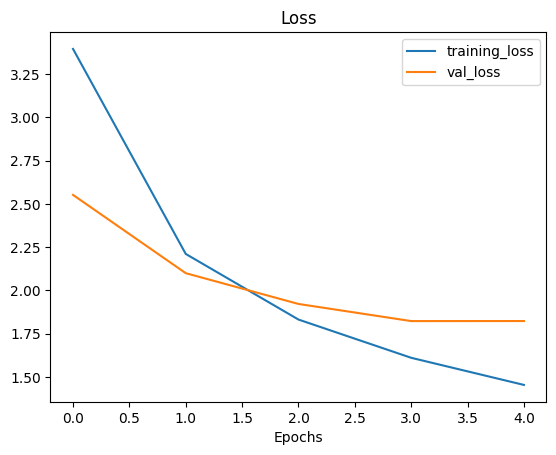

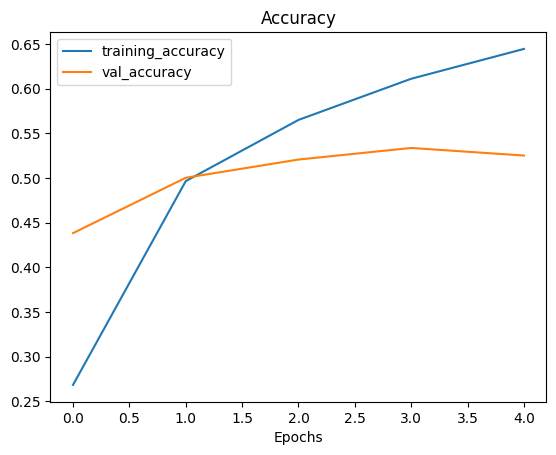

In [16]:
# Plot loss curves
plot_loss_curves(history_1_101_classes_10_percent)

## Fine-tuning

In [17]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
# Recompile model with lower learning rate (it's typically best practice to lower learning rate when fine-tuning)
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [19]:
# What layers in the model are trainable
for layer in model_1.layers:
  print(layer.name, layer.trainable)

input_layer True
sequential True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [20]:
# Check chich layer are trainable in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [21]:
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Fit the model continuing on last epoch from previous fit
history_2_101_classes_fine_tuning = model_1.fit(train_data_all_10_percent,
                                                steps_per_epoch=len(train_data_all_10_percent),
                                                epochs=fine_tune_epochs,
                                                initial_epoch=history_1_101_classes_10_percent.epoch[-1],
                                                validation_data=test_data,
                                                validation_steps=int(0.15 * len(test_data)),
                                                callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 67s 246ms/step - loss: 1.2022 - accuracy: 0.6888 - val_loss: 1.7597 - val_accuracy: 0.5389
Epoch 6/10
237/237 [==============================] - 55s 230ms/step - loss: 1.0965 - accuracy: 0.7094 - val_loss: 1.7400 - val_accuracy: 0.5463
Epoch 7/10
237/237 [==============================] - 49s 204ms/step - loss: 1.0058 - accuracy: 0.7308 - val_loss: 1.7287 - val_accuracy: 0.5485
Epoch 8/10
237/237 [==============================] - 48s 203ms/step - loss: 0.9435 - accuracy: 0.7493 - val_loss: 1.7638 - val_accuracy: 0.5421
Epoch 9/10
237/237 [==============================] - 50s 206ms/step - loss: 0.8897 - accuracy: 0.7571 - val_loss: 1.7710 - val_accuracy: 0.5381
Epoch 10/10
237/237 [==============================] - 45s 189ms/step - loss: 0.8439 - accuracy: 0.7757 - val_loss: 1.7484 - val_accuracy: 0.5440


In [22]:
model_1.evaluate(test_data)

790/790 [==============================] - 64s 81ms/step - loss: 1.5064 - accuracy: 0.6003


[1.506392002105713, 0.6002772450447083]

In [23]:
# !pip install tensorflow==2.9.1

In [24]:
model_1.save("/content/drive/MyDrive/saved_models/transfer-learning/101_classes_fine_tuning_efficient_net")

In [26]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/saved_models/transfer-learning/101_classes_fine_tuning_efficient_net")

In [27]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 65s 79ms/step - loss: 1.5064 - accuracy: 0.6003


[1.506392002105713, 0.6002772450447083]